# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [16]:
from dask.distributed import Client

client = Client("tcp://10.32.52.31:35431")
client

Client Scheduler: tcp://10.32.52.31:35431 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [5]:
ds_ll = faces_dataset_to_latlon(ds)

In [6]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [8]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row

In [9]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

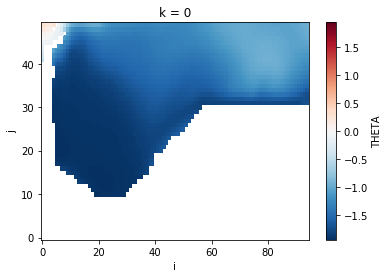

In [46]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [11]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

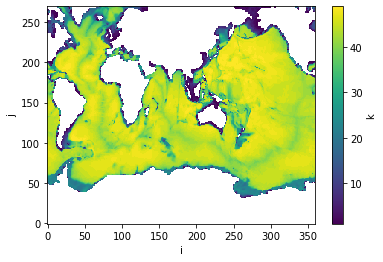

In [48]:
depth_max.plot()

In [10]:
bottom_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4'))
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range).load()

In [13]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [25]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [11]:
bottom_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [ ]:
bottom_temp_wg.to_netcdf('/home/jovyan/WMT/ECCO-budgets/bottom_temp_wg.nc', mode='w')

In [17]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

In [23]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

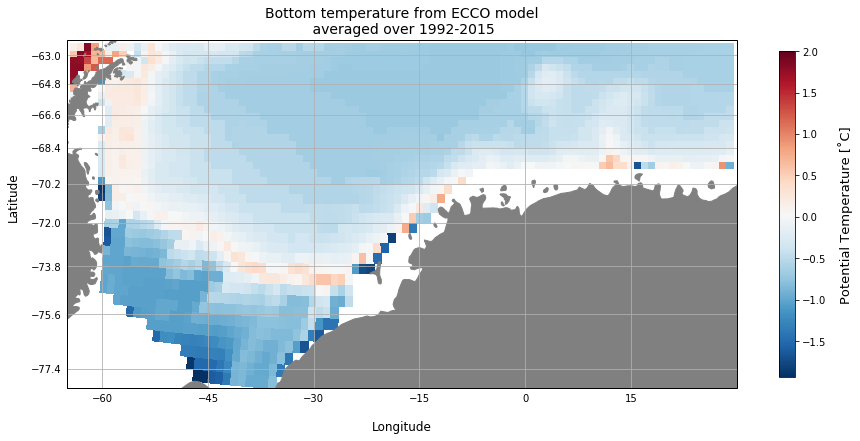

In [19]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [20]:
bottom_std_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_temp_wg = bottom_std_temp.isel(**lat_range, **lon_range)

In [21]:
bottom_std_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

In [22]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5

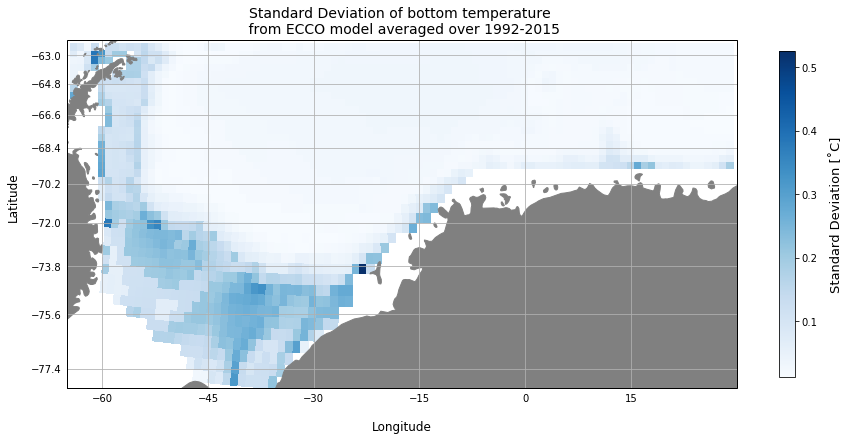

In [24]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

## Bottom Salinity

In [17]:
bottom_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4'))

In [18]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range).load()

In [19]:
bottom_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [20]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time').load()

In [21]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg_mean

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5

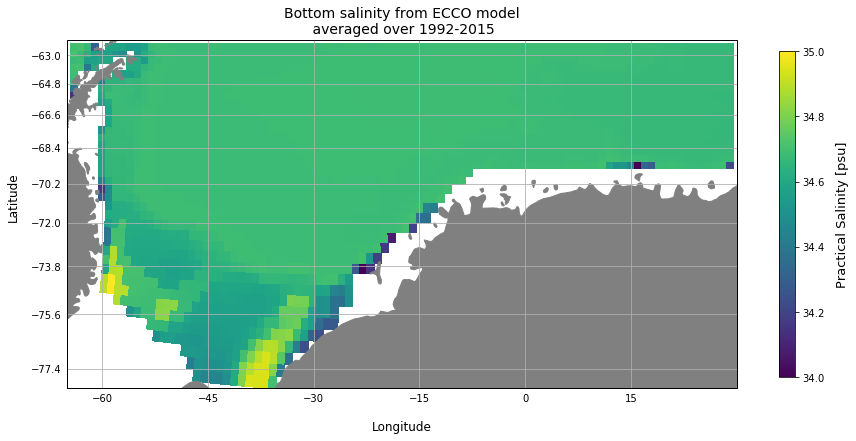

In [29]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [27]:
bottom_std_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_slt_wg = bottom_std_slt.isel(**lat_range, **lon_range)

In [33]:
bottom_std_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

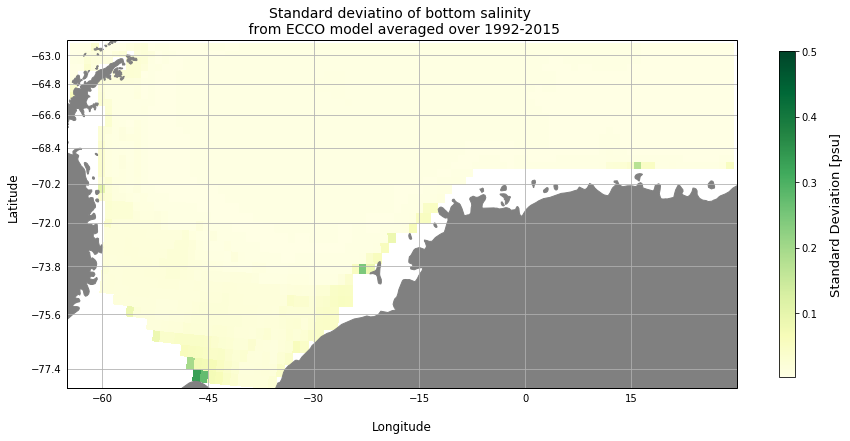

In [36]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='YlGn', vmax=0.5)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviatino of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

## <span style='color:Red'> Bottom Salinity Z-score (end)